### X.X Bi-directional LSTM

In [136]:
y_test.shape

(248, 2)

In [137]:
# Build model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
lstm_model.add(Bidirectional(LSTM(64, dropout=dropout_rate)))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
lstm_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_28 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1,188,610
Trainable params: 1,188,610
Non-trainable params: 0
_________________________________________________________________


In [138]:
# Fit model
lstm_model.fit(X_train,
               y_train,
               validation_data=(X_dev, y_dev),
               epochs=epochs,
               batch_size=batch_size,
               verbose=2
              )

Epoch 1/10
2/2 - 14s - loss: 0.6939 - accuracy: 0.4299 - val_loss: 0.6870 - val_accuracy: 0.5685 - 14s/epoch - 7s/step
Epoch 2/10
2/2 - 9s - loss: 0.6795 - accuracy: 0.5930 - val_loss: 0.6821 - val_accuracy: 0.5685 - 9s/epoch - 4s/step
Epoch 3/10
2/2 - 9s - loss: 0.6701 - accuracy: 0.5930 - val_loss: 0.6807 - val_accuracy: 0.5685 - 9s/epoch - 4s/step
Epoch 4/10
2/2 - 9s - loss: 0.6613 - accuracy: 0.5930 - val_loss: 0.6796 - val_accuracy: 0.5685 - 9s/epoch - 5s/step
Epoch 5/10
2/2 - 9s - loss: 0.6531 - accuracy: 0.5930 - val_loss: 0.6745 - val_accuracy: 0.5685 - 9s/epoch - 5s/step
Epoch 6/10
2/2 - 9s - loss: 0.6393 - accuracy: 0.6173 - val_loss: 0.6663 - val_accuracy: 0.6250 - 9s/epoch - 5s/step
Epoch 7/10
2/2 - 9s - loss: 0.6255 - accuracy: 0.6712 - val_loss: 0.6684 - val_accuracy: 0.5927 - 9s/epoch - 5s/step
Epoch 8/10
2/2 - 10s - loss: 0.6179 - accuracy: 0.6469 - val_loss: 0.6684 - val_accuracy: 0.6008 - 10s/epoch - 5s/step
Epoch 9/10
2/2 - 9s - loss: 0.6006 - accuracy: 0.6604 - val_

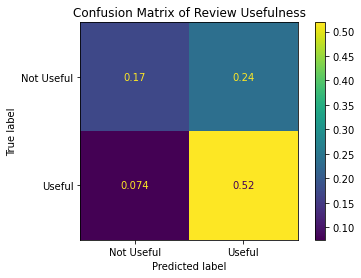

In [139]:
# Plot confusion matrix of training data
y_true = y_train.argmax(axis=1)
y_pred = np.argmax(lstm_model.predict(X_train), axis=1)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

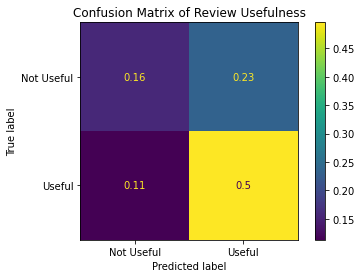

In [140]:
# Plot confusion matrix of test data
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [141]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.40      0.48        97
           1       0.68      0.81      0.74       151

    accuracy                           0.65       248
   macro avg       0.63      0.61      0.61       248
weighted avg       0.64      0.65      0.64       248



In [142]:
# Evaluate model
loss, acc = lstm_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

8/8 [==============================] - 1s 110ms/step - loss: 0.6631 - accuracy: 0.6532
Model performance metrics on test data
Accuracy: 0.6532
Loss: 0.6631
Precision: 0.6414
Recall: 0.6532
F1-score: 0.6372


In [ ]:
## X.X Explanation transfer learning

# from transformers.models.t5 import T5Model
from transformers import TFT5Model

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "max_seq_length": 128,
    "train_batch_size": 8,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "save_steps": -1,
    "use_multiprocessing": False,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "fp16": False,

    "wandb_project": "Question Generation with T5",
}

model = TFT5Model.from_pretrained("t5-small")

### X.X Pre-trained sentiment span extraction model

https://huggingface.co/mrm8488/t5-base-finetuned-span-sentiment-extraction

example = review_samples.iloc[2]['reviewText']

from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")

def get_sentiment_span(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

    generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

    predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return predicted_span
  
get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'

get_sentiment_span("question: negative context: {}".format(example))

review_samples.iloc[2]['reviewText']

